# Explore signal/price movement relationship

This is an example notebook to explore whether a trading signal results to profitable trades.

- It explores a small set of pairs on Uni v3 on Polygon
- Both long and short are considered (though shorts might be theoretical only, if such a lending market doest not exist in the point of time)

In [32]:
import datetime

import pandas as pd

from tradingstrategy.client import Client
from tradingstrategy.chain import ChainId
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.utils.default_strategies import get_default_strategies_path
from tradeexecutor.strategy.execution_context import notebook_execution_context
from tradeexecutor.utils.default_strategies import get_default_strategies_path
from tradeexecutor.strategy.strategy_module import read_strategy_module
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, load_trading_and_lending_data
from tradeexecutor.strategy.universe_model import UniverseOptions

client = Client.create_jupyter_client()

# Load preprocessed candle dataset
# See prepare-polygon-momentum-candles.py   
chain_id = ChainId.polygon
time_bucket = TimeBucket.d1
exchange_slugs = ["uniswap-v3", "quickswap"]
slug_str = "-and-".join(exchange_slugs)
fpath = f"/tmp/{chain_id.get_slug()}-{slug_str}-candles-{time_bucket.value}.parquet"
all_candles_df = pd.read_parquet(fpath)

# Filter out pair ids that belong to our target dataset
exchanges = client.fetch_exchange_universe()
exchange_ids = [exchanges.get_by_chain_and_slug(ChainId.polygon, s).exchange_id for s in exchange_slugs]
pairs_df = client.fetch_pair_universe().to_pandas()
pairs_df = pairs_df.loc[pairs_df["exchange_id"].isin(exchange_ids)]


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


### Interactive viewer mode

Set Plotly chart output mode to interactive viewing.

In [33]:
from tradeexecutor.utils.notebook import OutputMode, setup_charting_and_output

setup_charting_and_output(OutputMode.interactive, image_format="svg", max_rows=35)
#setup_charting_and_output(
#    OutputMode.static, 
#    image_format="png",
#    width=1500,
#    height=1200,    
#)

## Filter trading pairs

In [34]:
from tradingstrategy.pair import filter_for_stablecoins, StablecoinFilteringMode

good_quote_tokes = {"USDC", "WMATIC"}

# Remove pairs with expensive 1% fee tier
# Remove stable-stable pairs
tradeable_pairs_df = pairs_df.loc[pairs_df["fee"] <= 30]
tradeable_pairs_df = filter_for_stablecoins(tradeable_pairs_df, StablecoinFilteringMode.only_volatile_pairs)
tradeable_pairs_df = tradeable_pairs_df.loc[tradeable_pairs_df["quote_token_symbol"].isin(good_quote_tokes)]

# Denormalise pair ticker symbols on candles DataFrame 
tradeable_pairs_df["ticker"] = tradeable_pairs_df.apply(lambda r: f"{r.base_token_symbol}-{r.quote_token_symbol}-{r.fee}", axis=1)

pair_universe = PandasPairUniverse(tradeable_pairs_df, exchange_universe=exchanges)

# Narrow down candle data to pairs that are left after filtering
eligible_pair_ids = tradeable_pairs_df["pair_id"]
candles_df = all_candles_df.loc[all_candles_df["pair_id"].isin(eligible_pair_ids)].copy()

print(f"We have {len(tradeable_pairs_df)} tradeable pairs our of {len(pairs_df)} total loaded pairs")
print(f"We have {len(candles_df):,} candles for tradeable pairs, out of {len(all_candles_df):,} total candles")

# Denormalise pair data on candles dataframe
# https://stackoverflow.com/questions/62133801/copy-a-column-value-from-another-dataframe-based-on-a-condition
candles_df["timestamp"] = candles_df.index  # Index is lost in merge?
candles_df = candles_df.merge(tradeable_pairs_df[["pair_id", "ticker", "exchange_slug"]], on="pair_id", how="left")
candles_df = candles_df.set_index("timestamp")

We have 3697 tradeable pairs our of 5751 total loaded pairs
We have 1,080,827 candles for tradeable pairs, out of 1,655,927 total candles


## Explore signal vs price change

Create a function `calculate_signal_vs_profit` which calculates 
- Signal (naive momentum)
- Profit: the last and the best future price we can get
- Allows us to play around with different time windows
- Split between shorts and longs


In [35]:
import humanize

# Set up parameters of time windows
# we use for this notebook run
momentum_window = pd.Timedelta(days=7)
ma_short = 14
ma_long = 21
profit_window = pd.Timedelta(days=7)
volume_threshold = 25_000


# Use later in chart titles
signal_window_label = humanize.naturaldelta(momentum_window)
profit_window_label = humanize.naturaldelta(profit_window)

Create a function `calculate_signal_vs_price_for_pair` which calculates 
- Calculates the signal vs. for certain trading pair
- Bundle few different pairs to the same `DataFrame` so we can examine them together


In [38]:
from typing import List
import numpy as np
from pandas.core.groupby import DataFrameGroupBy
from pandas.tseries.frequencies import to_offset
from pandas_ta import ema

from tradingstrategy.utils.forward_fill import forward_fill
from tradingstrategy.pair import DEXPair


def calculate_signal_vs_profit(
    df: pd.DataFrame, 
    pair: DEXPair,
    momentum_window: pd.Timedelta, 
    profit_window: pd.Timedelta,
    time_frame: pd.Timedelta,        
) -> pd.DataFrame:
    """Calculate signals and profits for all incoming candles."""
    
    # Create entries for past price to be used for signal
    # and future price (used for the price correlation)
    momentum_offset = to_offset(momentum_window)
    profit_offset = to_offset(profit_window)

    # Fix missing prices
    df["open"] = df["open"].replace(0, np.NaN)

    df["prev"] = df["open"].shift(freq=momentum_offset)
    df["next"] = df["open"].shift(freq=-profit_offset)

    # What is our predicted price
    df["price_diff"] = (df["next"] - df["open"]) / df["open"]  # Get the profit on the final day of profit window

    # Calculate signal from the past and price difference to the future
    df["momentum"] = (df["prev"] - df["open"]) / df["open"]
    
    df["ma_long"] = ema(df["open"], length=ma_long) 
    df["ma_short"] = ema(df["open"], length=ma_short)
    
    # Positive difference when current price > short term moving average
    df["ma_diff"] = (df["open"] - df["ma_short"]) / df["open"]

    df["bullish"] = df["ma_diff"] >= 0
    df["bearish"] = df["ma_diff"] < 0

    df["signal"] = 0
    df.loc[df["bullish"] & (df["momentum"] >= 0), "signal"] = df["momentum"]
    df.loc[df["bearish"] & (df["momentum"] < 0), "signal"] = df["momentum"]
    df["signal"] = df["momentum"]

    # On negative signals, we go short.
    # On zero signal and lack of data set side to NA
    df["side"] = pd.NA
    
    df.loc[df["signal"] > 0, "side"] = "long"
    df.loc[df["signal"] < 0, "side"] = "short"

    number_of_candles = profit_window / time_frame
    assert number_of_candles > 0 and number_of_candles.is_integer(), f"Could not calculate candle count that fits into profit window {profit_window} for data time frame {time_frame}"
    number_of_candles = int(number_of_candles)

    # Max and min price wihtin the profit window will determine the profit for longs and shorts respective
    df["max_future_price"] = df["close"].rolling(number_of_candles).max().shift(-number_of_candles) # Get the max profit on the profit window, assuming take profit %
    df["min_future_price"] = df["close"].rolling(number_of_candles).min().shift(-number_of_candles) # Get the max profit on the profit window, assuming take profit %    
    
    # Calculate profit separately for longs and shorts
    # using Pandas Mask
    # https://stackoverflow.com/a/33770421/315168
    #
    # We calculate both profit after X time,
    # and also max take profit, assuming
    # we could do a perfect trailing stop loss
    #
    longs = (df["side"] == "long")
    shorts = (df["side"] == "short")
    df.loc[longs, "profit"] = df["price_diff"]
    df.loc[shorts, "profit"] = -df["price_diff"]
    df.loc[longs, "profit_max"] = (df["max_future_price"] - df["open"]) / df["open"]  # Get the profit based on max price
    df.loc[shorts, "profit_max"] = -(df["min_future_price"] - df["open"]) / df["open"]  # Get the profit based on max price

    df.loc[longs, "desc"] = df.agg('{0[ticker]} long'.format, axis=1)
    df.loc[shorts, "desc"] = df.agg('{0[ticker]} short'.format, axis=1)
    
    return df


def calculate_signal_vs_price_for_pair(
    grouped_candles: DataFrameGroupBy,
    pair: DEXPair
) -> pd.DataFrame:
    """Calculate signal vs. profit ratio for an individual pair."""
    try:
        df = grouped_candles.get_group(pair.pair_id).copy()
    except KeyError:
        # Scam pairs 
        return pd.DataFrame()
    
    # Remove candles with zero vol
    df = df.loc[df["volume"] >= volume_threshold]
    
    df = calculate_signal_vs_profit(
        df,
        pair,
        momentum_window,
        profit_window,
        time_frame=time_bucket.to_pandas_timedelta(),
    )
    return df

print("Calculating signals")
grouped_candles = candles_df.groupby("pair_id")
all_pairs = tradeable_pairs_df.groupby("pair_id")
per_pair_data = [calculate_signal_vs_price_for_pair(grouped_candles, pair) for pair in pair_universe.iterate_pairs()]
df = pd.concat(per_pair_data)    


# Example trading pair chart

Plot with our indicators



In [ ]:
from tradingstrategy.charting.candle_chart import visualise_ohlcv

import plotly.graph_objects as go

# Pick single pair to examine
# The first pair is ETH-USD
examined_pair = pair_universe.get_pair_by_human_description((ChainId.polygon, "uniswap-v3", "WETH", "USDC", 0.0005))
single_df = df.loc[df["pair_id"] == examined_pair.pair_id]

# display(eth_usd_df)

fig = visualise_ohlcv(
    single_df,
    num_detached_indicators=3,
    subplot_names=["Price", "Signal", "Momentum", "MA diff"],
)

fig.add_trace(
    go.Scatter(name="MA long", x=single_df.index, y=single_df["ma_long"]),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(name="MA short", x=single_df.index, y=single_df["ma_short"]),
    row=1,
    col=1,
)


fig.add_trace(
    go.Scatter(name="Signal", x=single_df.index, y=single_df["signal"]),
    row=2,
    col=1,
)

fig.add_trace(
    go.Scatter(name="Momentum", x=single_df.index, y=single_df["momentum"]),
    row=3,
    col=1,
)

fig.add_trace(
    go.Scatter(name="MA diff", x=single_df.index, y=single_df["ma_diff"]),
    row=4,
    col=1,
)

fig.show()

# display(single_df)

,open,high,low,close,pair,prev,next,price_diff,momentum,ma_long,...,ma_diff,bullish,bearish,signal,side,max_future_price,min_future_price,profit,profit_max,desc
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01,3685.288207,3787.845027,3682.032735,3761.470924,WETH-USDC,NaN,3187.555700,-0.135059,NaN,NaN,...,NaN,False,False,NaN,<NA>,3825.436519,3088.833621,NaN,NaN,NaN
2022-01-02,3761.467727,3839.370147,3729.533679,3825.436519,WETH-USDC,NaN,3088.858725,-0.178816,NaN,NaN,...,NaN,False,False,NaN,<NA>,3793.188319,3088.833621,NaN,NaN,NaN
2022-01-03,3825.422534,3835.795922,3682.045654,3762.704674,WETH-USDC,NaN,3157.787411,-0.174526,NaN,NaN,...,NaN,False,False,NaN,<NA>,3793.188319,3074.473137,NaN,NaN,NaN
2022-01-04,3762.703879,3883.253812,3721.987381,3793.188319,WETH-USDC,NaN,3074.478128,-0.182907,NaN,NaN,...,NaN,False,False,NaN,<NA>,3548.044807,3074.473137,NaN,NaN,NaN
2022-01-05,3792.128363,3835.024346,3204.987672,3548.044807,WETH-USDC,NaN,3242.448739,-0.144953,NaN,NaN,...,NaN,False,False,NaN,<NA>,3416.130030,3074.473137,NaN,NaN,NaN
2022-01-06,3547.886565,3547.886565,3184.831886,3416.130030,WETH-USDC,NaN,3371.590403,-0.049690,NaN,NaN,...,NaN,False,False,NaN,<NA>,3371.592158,3074.473137,NaN,NaN,NaN
2022-01-07,3416.129362,3416.129362,3003.808231,3186.759510,WETH-USDC,NaN,3245.739963,-0.049878,NaN,NaN,...,NaN,False,False,NaN,<NA>,3371.592158,3074.473137,NaN,NaN,NaN
2022-01-08,3187.555700,3240.457393,2900.073742,3088.833621,WETH-USDC,3685.288207,3304.651779,0.036735,0.156149,NaN,...,NaN,False,False,0.156149,long,3371.592158,3074.473137,0.036735,0.057736,WETH-USDC long
2022-01-09,3088.858725,3211.868842,3066.767226,3157.802925,WETH-USDC,3761.467727,3329.558779,0.077925,0.217753,NaN,...,NaN,False,False,0.217753,long,3371.592158,3074.473137,0.077925,0.091533,WETH-USDC long


## Plot signal vs. price samples

Different scatter charts to examine if there is a correlation between the signal and the profit.

In [59]:
import plotly.express as px

# Find maximum momentum df
profit_df = df.copy()
#profit_df.index = pd.MultiIndex.from_arrays([df.index, df["pair"]])
profit_df["signal"] = profit_df["signal"].fillna(0).replace([np.inf, -np.inf], 0)
profit_df["profit"] = profit_df["profit"].fillna(0).replace([np.inf, -np.inf], 0)
profit_df["profit_max"] = profit_df["profit_max"].fillna(0).replace([np.inf, -np.inf], 0)
profit_df["timestamp"] = profit_df.index
print(f"Total results {len(df):,}")
#display(profit_df)

#max_df = df.loc[df.groupby("timestamp")['signal'].idxmax()]
# max_df = df.groupby("timestamp")["profit"].max()
max_df = profit_df.sort_values('signal', ascending=False).drop_duplicates("timestamp")
# max_df["signal"] = profit_df["signal"].fillna(0)
print(f"Max results {len(max_df):,}")
# display(max_df)

display(max_df)


Total results 1,080,827
Max results 1,127


,pair_id,open,high,low,close,volume,ticker,exchange_slug,prev,next,...,bullish,bearish,signal,side,max_future_price,min_future_price,profit,profit_max,desc,timestamp
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-06-18,2650864,2.112052e-18,2.112052e-18,2.112052e-18,2.112052e-18,0.000000,2DT-WMATIC-30,quickswap,2.499004e+18,2.112052e-18,...,False,False,1.183212e+36,long,2.112052e-18,2.112052e-18,0.000000,0.000000,2DT-WMATIC-30 long,2022-06-18
2022-07-08,2650829,4.069657e-13,4.069657e-13,4.069657e-13,4.069657e-13,0.000000,CPLE-WMATIC-30,quickswap,4.291443e+20,4.069657e-13,...,False,True,1.054498e+33,long,4.069657e-13,4.069657e-13,0.000000,0.000000,CPLE-WMATIC-30 long,2022-07-08
2022-06-27,2650829,6.609278e-13,6.609278e-13,6.609278e-13,6.609278e-13,0.000000,CPLE-WMATIC-30,quickswap,9.924595e+19,4.069657e-13,...,False,False,1.501616e+32,long,7.091373e-13,4.444530e-16,-0.384251,0.072942,CPLE-WMATIC-30 long,2022-06-27
2022-07-10,2650829,4.069657e-13,4.069657e-13,4.069657e-13,4.069657e-13,0.000000,CPLE-WMATIC-30,quickswap,7.169886e+18,4.069657e-13,...,False,True,1.761791e+31,long,4.069657e-13,4.069657e-13,0.000000,0.000000,CPLE-WMATIC-30 long,2022-07-10
2022-07-09,2650829,4.069657e-13,4.069657e-13,4.069657e-13,4.069657e-13,0.000000,CPLE-WMATIC-30,quickswap,3.309904e+18,4.069657e-13,...,False,True,8.133129e+30,long,4.069657e-13,4.069657e-13,0.000000,0.000000,CPLE-WMATIC-30 long,2022-07-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-10,93770,2.284833e+00,2.960750e+00,1.838269e+00,1.954837e+00,6632.504883,EASY-USDC-30,quickswap,NaN,1.238122e+00,...,False,False,0.000000e+00,NaN,1.957210e+00,1.236932e+00,0.000000,0.000000,NaN,2020-10-10
2020-10-11,93770,1.928284e+00,2.139212e+00,1.859243e+00,1.957210e+00,6262.421387,EASY-USDC-30,quickswap,NaN,1.182994e+00,...,False,False,0.000000e+00,NaN,1.611496e+00,1.134777e+00,0.000000,0.000000,NaN,2020-10-11
2020-10-12,93770,1.956858e+00,2.003059e+00,1.551423e+00,1.553056e+00,14215.293945,EASY-USDC-30,quickswap,NaN,1.135422e+00,...,False,False,0.000000e+00,NaN,1.611496e+00,1.134777e+00,0.000000,0.000000,NaN,2020-10-12


In [60]:

#display(df)
#display(max_df)

fig = px.scatter(
    df, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    # color="desc", 
    title=f"Max potential take profit, signal {signal_window_label}, profit window {profit_window_label}",
    #marginal_x="histogram", 
    #marginal_y="rug"
)
fig.update_layout(legend=dict(title='Pair and direction'))
fig.show()

fig = px.scatter(
    max_df, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    title=f"Profit last day, signal {signal_window_label}, profit window {profit_window_label}",
    #marginal_x="histogram", 
    #marginal_y="rug"    
)
fig.update_layout(legend=dict(title='Pair and direction'))
fig.show()

MissingDataError: exog contains inf or nans

### Long only vs. short 

Examine trade types separately to better see if one side is clearly superior.

In [ ]:
df_long_only = df.loc[df["side"] == "long"]

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    color="desc", 
    title=f"Long only max take profit, signal {signal_window_label}, profit window {profit_window_label}",

)
fig.show()

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    color="desc", 
    title=f"Long only profit last day, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Long only max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Long only last profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()



In [ ]:
df_short_only = df.loc[df["side"] == "short"]

fig = px.scatter(
    df_short_only, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    color="desc", 
    title=f"Short only max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    df_short_only, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    color="desc", 
    title=f"Short only profit last day, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

### Filtered signal

Remove low signals below a certain threshold and see if it affects the correlation between the signal and the profit.

In [ ]:

threshold = 0.075

filtered_df = df_long_only.loc[abs(df_long_only["signal"]) >= threshold]

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Long-only filtered the signal at {threshold}, max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Long-only filtered the signal at {threshold}, profit last day, signal {signal_window_label}, profit window {profit_window_label}")
fig.show()

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"No filter, profit last day, signal {signal_window_label}, profit window {profit_window_label}")
fig.show()

filtered_df = df_short_only.loc[abs(df_short_only["signal"]) >= threshold]

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Short only filtered the signal at {threshold}, max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Short only filtered the signal at {threshold}, profit last day, signal {signal_window_label}, profit window {profit_window_label}")
fig.show()

## Heatmap

Invidual point cloud is hard to interpret, so render it as a heatmap instead.

In [ ]:

clipped_df = df.loc[abs(df["signal"]) < 0.2]

fig = px.density_heatmap(
    clipped_df, 
    x="signal", 
    y="profit", 
    nbinsx=50, 
    title="Signal vs. profit"

)
fig.show()

#weth = df.loc[df["pair"] == "WETH-UDSC long"]
#fig = px.density_heatmap(df, x="signal", y="profit_max", nbinsx=30, title="WETH")
#fig.show()

## Hexbin plot

Try to make more sense from the point cloud.

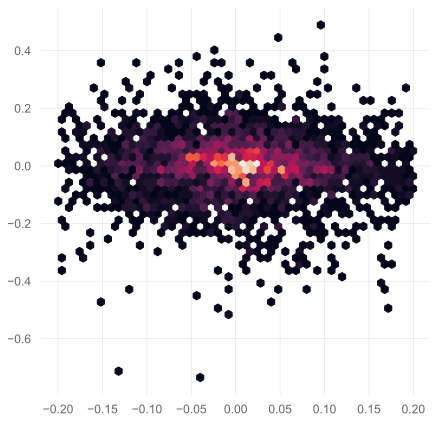

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import cmocean#  http://matplotlib.org/cmocean/

plt.figure(figsize=(7, 7))
ax = plt.hexbin(clipped_df["signal"], clipped_df["profit"], gridsize=50, mincnt=1) # cmocean.cm.algae is a cmocean colormap
# plt.set_title("Signal vs. Price matches")
plt.show()
# display(df)